<a href="https://colab.research.google.com/github/WarLord7821/Cloud-Computing-and-Devops_aws-microservice-fastapi-ecs-fargate-alb-lambda/blob/main/DTC_%2B_Random_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet category_encoders scikit-learn==1.6.1 seaborn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score
)
from scipy.stats import randint as sp_randint, uniform as sp_uniform

from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce  # optional, used if you want TargetEncoder


In [ ]:
# Load UCI_Credit_Card.csv
# Option A: From Google Drive (mount first)
# from google.colab import drive
# drive.mount('/content/drive')
# path = "/content/drive/MyDrive/UCI_Credit_Card.csv"

# Option B: Upload directly (Colab file picker)
from google.colab import files
print("Please upload UCI_Credit_Card.csv (use the file picker).")
uploaded = files.upload()
fname = list(uploaded.keys())[0]
print("Loaded file:", fname)
df = pd.read_csv(fname)

print("Shape:", df.shape)
df.head()



Please upload UCI_Credit_Card.csv (use the file picker).


Saving UCI_Credit_Card.csv to UCI_Credit_Card.csv
Loaded file: UCI_Credit_Card.csv
Shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Columns: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month']

Dtypes:
 ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


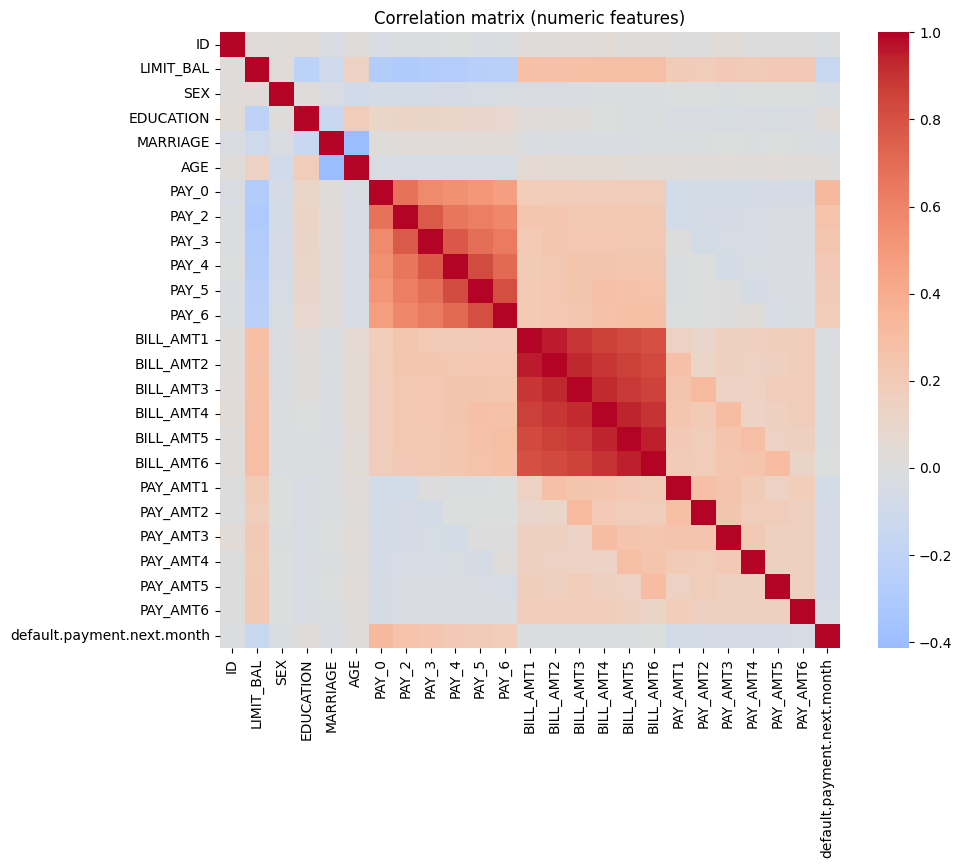

In [ ]:
# Basic EDA
print("Columns:", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())

# Detect common target names in this dataset
target_candidates = [c for c in df.columns if 'default' in c.lower() or 'next' in c.lower()]
print("Target candidates found:", target_candidates)

# Choose target: common name in UCI_credit_card variants is 'default.payment.next.month'
if 'default.payment.next.month' in df.columns:
    target = 'default.payment.next.month'
elif 'default_payment_next_month' in df.columns:
    target = 'default_payment_next_month'
elif 'default.payment.nextmonth' in df.columns:
    target = 'default.payment.nextmonth'
else:
    # fallback: choose last column if unsure
    target = df.columns[-1]
print("Using target column:", target)

# Target distribution
print("\nTarget value counts:\n", df[target].value_counts())
print("\nTarget proportions:\n", df[target].value_counts(normalize=True))

# Quick numeric summary
display(df.describe().T)

# Correlation (numeric)
num_cols = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', center=0)
plt.title("Correlation matrix (numeric features)")
plt.show()


In [ ]:
# Duplicates
print("Duplicate rows:", df.duplicated().sum())
if df.duplicated().sum() > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Dropped duplicates, new shape:", df.shape)

# Missing values fraction
miss_frac = df.isnull().mean()
print("Missing fraction (cols with any missing):")
print(miss_frac[miss_frac>0].sort_values(ascending=False))


Duplicate rows: 0
Missing fraction (cols with any missing):
Series([], dtype: float64)


In [ ]:
# Winsorize numeric columns to reduce outlier effect (IQR method)
def winsorize_df(df_in, numeric_cols):
    df = df_in.copy()
    for c in numeric_cols:
        Q1 = df[c].quantile(0.25)
        Q3 = df[c].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[c] = np.where(df[c] < lower, lower, df[c])
        df[c] = np.where(df[c] > upper, upper, df[c])
    return df

numeric_for_win = [c for c in df.select_dtypes(include=np.number).columns.tolist() if c != target and c.lower() not in ['id']]
print("Numeric columns to cap (sample):", numeric_for_win[:10])
df = winsorize_df(df, numeric_for_win)
print("Outliers capped using IQR winsorization.")


Numeric columns to cap (sample): ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5']
Outliers capped using IQR winsorization.


In [ ]:
# Identify numeric vs categorical-ish
all_numeric = df.select_dtypes(include=np.number).columns.tolist()
# treat small-unique-count numeric columns as categorical (e.g., SEX, EDUCATION)
cat_like = [c for c in df.columns if (df[c].nunique() <= 6 and c != target and c not in ['ID','id'])]
# Final lists
numeric_cols = [c for c in all_numeric if c not in cat_like + [target,'ID','id']]
categorical_cols = [c for c in cat_like if c != target]

print("Numeric cols (count):", len(numeric_cols))
print("Categorical-like cols:", categorical_cols)

# Quick encoding:
# - For columns with 2 unique values -> map to 0/1
# - For multi-categorical -> use OrdinalEncoder inside pipeline (to avoid target leakage)
for c in categorical_cols:
    if df[c].nunique() == 2:
        vals = df[c].dropna().unique().tolist()
        df[c] = df[c].map({vals[0]: 0, vals[1]: 1})
        # keep in numeric_cols now
        if c not in numeric_cols:
            numeric_cols.append(c)

# Recompute categorical columns after binary mapping
categorical_cols = [c for c in categorical_cols if df[c].nunique() > 2]
print("Remaining multi-cat cols to encode later:", categorical_cols)

display(df.head())


Numeric cols (count): 14
Categorical-like cols: ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
Remaining multi-cat cols to encode later: ['EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,0,2.0,1.0,24.0,1.5,1.5,-1.0,-1.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,0,2.0,2.0,26.0,-1.0,1.5,0.0,0.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,...,20940.0,19146.0,19131.0,2000.0,11250.5,10000.0,9000.0,689.0,679.0,0


In [ ]:
# Prepare X, y
X = df.drop(columns=[target] + (['ID'] if 'ID' in df.columns else []))
y = df[target]

# Stratified split (preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Positive fraction (train):", y_train.mean())

# Build ColumnTransformer:
num_features = [c for c in X_train.columns if c in numeric_cols]
cat_features = [c for c in X_train.columns if c in categorical_cols]

print("Num feats:", len(num_features), "Cat feats:", len(cat_features))

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # Decision trees don't require scaling, but we keep scaler optional
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
], remainder='drop')

# Fit-transform training data and transform test
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Convert back to DataFrame for convenience (column names)
proc_cols = num_features + cat_features
X_train_proc = pd.DataFrame(X_train_proc, columns=proc_cols, index=X_train.index)
X_test_proc = pd.DataFrame(X_test_proc, columns=proc_cols, index=X_test.index)

print("Processed shapes:", X_train_proc.shape, X_test_proc.shape)


Train shape: (24000, 23) Test shape: (6000, 23)
Positive fraction (train): 0.22120833333333334
Num feats: 15 Cat feats: 8
Processed shapes: (24000, 23) (6000, 23)


Accuracy: 0.7153333333333334
ROC AUC: 0.6031708071073529

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.81      4673
           1       0.37      0.40      0.38      1327

    accuracy                           0.72      6000
   macro avg       0.60      0.60      0.60      6000
weighted avg       0.72      0.72      0.72      6000



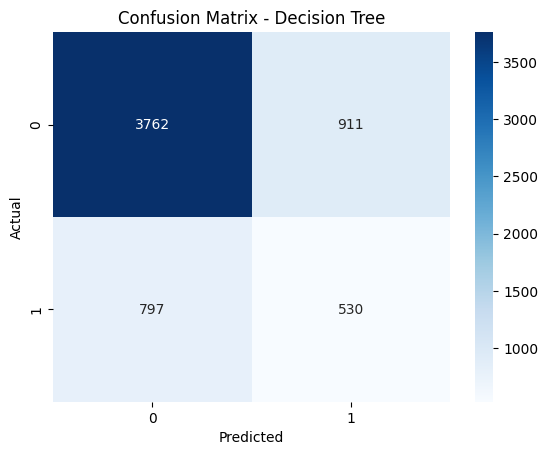

,feature,importance
17,PAY_0,0.159368
2,AGE,0.073584
3,BILL_AMT1,0.068396
0,LIMIT_BAL,0.067857
11,PAY_AMT3,0.056857
10,PAY_AMT2,0.052022
14,PAY_AMT6,0.050496
8,BILL_AMT6,0.048386
9,PAY_AMT1,0.046561
5,BILL_AMT3,0.045696


In [ ]:
# Baseline Decision Tree
dtc = DecisionTreeClassifier(random_state=42)

# Fit
dtc.fit(X_train_proc, y_train)

# Predict & evaluate
y_prob = dtc.predict_proba(X_test_proc)[:,1] if hasattr(dtc, "predict_proba") else None
y_pred = dtc.predict(X_test_proc)

print("Accuracy:", accuracy_score(y_test, y_pred))
if y_prob is not None:
    try:
        print("ROC AUC:", roc_auc_score(y_test, y_prob))
    except:
        pass

print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix - Decision Tree")
plt.show()

# Feature importance
fi = pd.DataFrame({'feature': proc_cols, 'importance': dtc.feature_importances_}).sort_values('importance', ascending=False)
display(fi.head(20))


In [ ]:
# Parameter distributions
param_dist = {
    'max_depth': sp_randint(2, 30),
    'min_samples_split': sp_randint(2, 200),
    'min_samples_leaf': sp_randint(1, 100),
    'max_features': sp_uniform(0.2, 0.8),  # fraction of features to consider at each split
    'criterion': ['gini', 'entropy']
}

# Use pipeline to combine preprocessor + estimator so CV is safe
pipe = Pipeline(steps=[
    ('pre', preprocessor),  # note: preprocessor will be refit inside CV folds
    ('clf', DecisionTreeClassifier(random_state=42))
])

# Wrap parameters to reference the pipeline's classifier
param_dist_pipe = {
    'clf__max_depth': param_dist['max_depth'],
    'clf__min_samples_split': param_dist['min_samples_split'],
    'clf__min_samples_leaf': param_dist['min_samples_leaf'],
    'clf__max_features': param_dist['max_features'],
    'clf__criterion': param_dist['criterion']
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    pipe, param_distributions=param_dist_pipe, n_iter=40,
    scoring='roc_auc', n_jobs=-1, cv=cv, verbose=2, random_state=42
)

# Fit randomized search on training set (this will fit preprocessor within each CV fold)
rs.fit(X_train, y_train)

print("Best CV AUC:", rs.best_score_)
print("Best params:", rs.best_params_)


Fitting 4 folds for each of 40 candidates, totalling 160 fits
Best CV AUC: 0.7628075875942026
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 13, 'clf__max_features': np.float64(0.21844994003313262), 'clf__min_samples_leaf': 91, 'clf__min_samples_split': 60}


Test ROC AUC (best): 0.7505059206708002
Test Accuracy (best): 0.8173333333333334

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      4673
           1       0.68      0.33      0.45      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.64      0.67      6000
weighted avg       0.80      0.82      0.79      6000



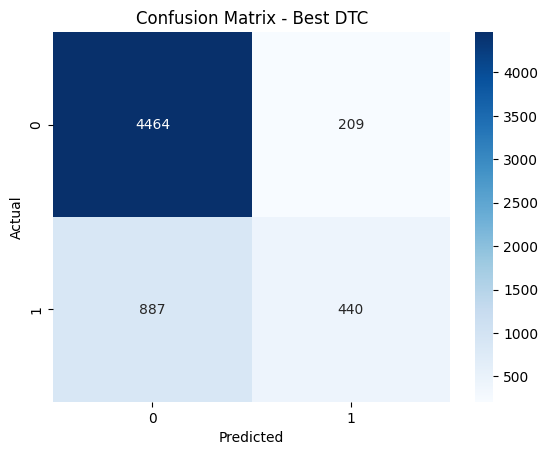

,feature,importance
17,PAY_0,0.561774
19,PAY_3,0.124177
18,PAY_2,0.041072
6,BILL_AMT4,0.038812
21,PAY_5,0.031515
12,PAY_AMT4,0.025646
0,LIMIT_BAL,0.021368
13,PAY_AMT5,0.021191
9,PAY_AMT1,0.017254
3,BILL_AMT1,0.016225


Saved model to dtc_randomsearch_best.joblib


In [ ]:
best = rs.best_estimator_

# Predict on processed test set (pipeline will preprocess automatically)
y_prob_best = best.predict_proba(X_test)[:,1]
y_pred_best = best.predict(X_test)

print("Test ROC AUC (best):", roc_auc_score(y_test, y_prob_best))
print("Test Accuracy (best):", accuracy_score(y_test, y_pred_best))
print("\nClassification report:\n", classification_report(y_test, y_pred_best))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix - Best DTC")
plt.show()

# Feature importances from the fitted decision tree (inside pipeline)
best_clf = best.named_steps['clf']
best_cols = num_features + cat_features
fi = pd.DataFrame({'feature': best_cols, 'importance': best_clf.feature_importances_}).sort_values('importance', ascending=False)
display(fi.head(20))

# Save model
joblib.dump(best, "dtc_randomsearch_best.joblib")
print("Saved model to dtc_randomsearch_best.joblib")


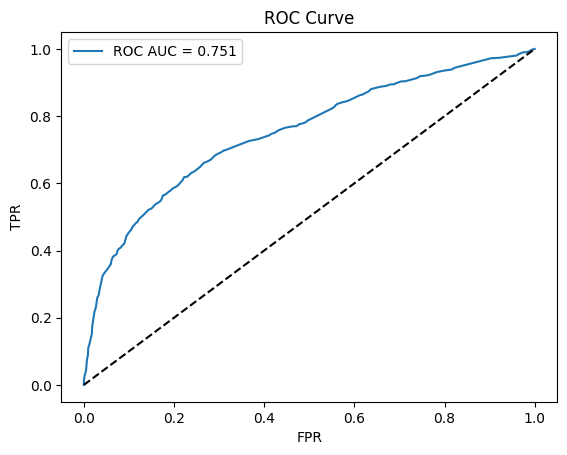

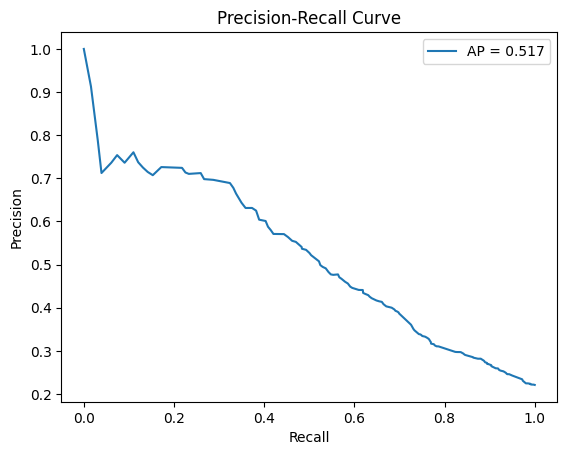

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

fpr, tpr, _ = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend()
plt.show()

prec, rec, _ = precision_recall_curve(y_test, y_prob_best)
ap = average_precision_score(y_test, y_prob_best)
plt.figure()
plt.plot(rec, prec, label=f'AP = {ap:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend()
plt.show()
